In [16]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# pd.options.display.max_columns = 15
# pd.options.display.max_colwidth = 1000

In [158]:

dictionary_df = {} # a dictionary of dataframes, 1 for each football league

## Get the data from each league and put in a df
football_data_path = '../Football-Dataset/'
for (dirpath, dirnames, filenames) in os.walk(football_data_path):
    for filename in filenames:
        if filename != '.DS_Store':
            dictionary_df[filename[:-4]] = pd.read_csv(dirpath + '/' + filename)

number_of_datasets = len(dictionary_df) # 448
# remove empty dataframes from the dictionary:
empty_dataframes = [key for key, value in dictionary_df.items() if value.empty]
for key in empty_dataframes:
    dictionary_df.pop(key)        
number_of_datasets = len(dictionary_df) # 404 

for key, df in dictionary_df.items():
    duplicates = df[df.duplicated(subset='Link')]
    if duplicates.empty:
        pass
    else:
        pass
        # print(key)



In [185]:
#calculate the match result ('H', 'A' or 'D')
# goal_difference = Home_goals - Away_goals
def match_result_from_goals(goal_difference):
    if goal_difference > 0:
        return 'H'
    elif goal_difference < 0:
        return 'A'
    else:
        return 'D'

# add a match id col and check for missing/invalid data:

i = 1
for key, value in dictionary_df.items():
    j = i+len(value.index)
    ids = list(range(i, j))
    value.insert(0, 'Match_id', ids)  
    value.set_index("Match_id", inplace = True)
    i=j
    
    value[['Home_goals', 'Away_goals']] = value['Result'].str.split('-', expand=True)
    # # convert data type of home goals/ away goals to numeric, need to remove a few rows where the data is ambiguous 
    errors = pd.to_numeric(value['Home_goals'], errors='coerce').isnull()
    e = errors.loc[errors==True]
    # drop rows where there is an invalid format 
    value.drop(e.index.to_list(), inplace=True)
    #convert cols to numeric where appropriate
    value[['Home_goals', 'Away_goals', 'Round', 'Season']] = value[['Home_goals', 'Away_goals', 'Round', 'Season']].apply(pd.to_numeric)
    # value.reset_index(inplace=True)
    value['Match_goal_difference'] = value['Home_goals'] - value['Away_goals']
    value['Match_result'] = (value['Match_goal_difference']).apply(match_result_from_goals)

# print(dictionary_df['Results_2020_primeira_liga'])

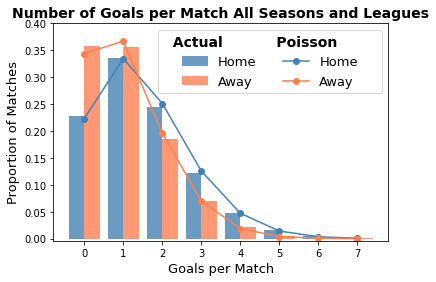

In [168]:
from scipy.stats import poisson

all_leagues_df = pd.concat(dictionary_df.values(), ignore_index=True)

home_away_goals = all_leagues_df[['Home_goals', 'Away_goals']]

 # calculate Poisson probability  for home goals and away goals 
poisson_prob = np.column_stack([[poisson.pmf(i, home_away_goals.mean()[j]) for i in range(8)] for j in range(2)])

# plot histogram of actual goals
plt.hist(home_away_goals[['Home_goals', 'Away_goals']].values, range(9), 
         alpha=0.8, label=['Home', 'Away'],density=True, color=["steelblue", "coral"])

# add lines for the Poisson distributions
plt.plot([i-0.5 for i in range(1,9)], poisson_prob[:,0],
                  linestyle='-', marker='o',label="Home", color = 'steelblue')
plt.plot([i-0.5 for i in range(1,9)], poisson_prob[:,1],
                  linestyle='-', marker='o',label="Away", color = 'coral')


leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("  Actual           Poisson        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(8)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match All Seasons and Leagues",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()   


In [196]:
print(all_leagues_df[['Home_goals', 'Away_goals']].mean())
print(all_leagues_df[['Home_goals', 'Away_goals']].var())
# small overdispersion but mean approx equal to var so poisson appropriate


Home_goals    1.500799
Away_goals    1.067499
dtype: float64
Home_goals    1.589947
Away_goals    1.170656
dtype: float64


/var/folders/1k/nj5s4vvs6b1758sjrdg0hd_40000gp/T/ipykernel_11463/1280575028.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_leagues_df.groupby('League')['Home_goals', 'Away_goals'].mean().sort_values('Home_goals').plot(kind='barh')


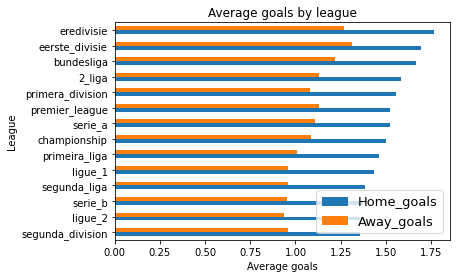

/var/folders/1k/nj5s4vvs6b1758sjrdg0hd_40000gp/T/ipykernel_11463/1280575028.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_leagues_df.groupby('League')['Home_goals', 'Away_goals'].agg(['mean','var']).plot(kind='barh', width=1, figsize=(20,10))


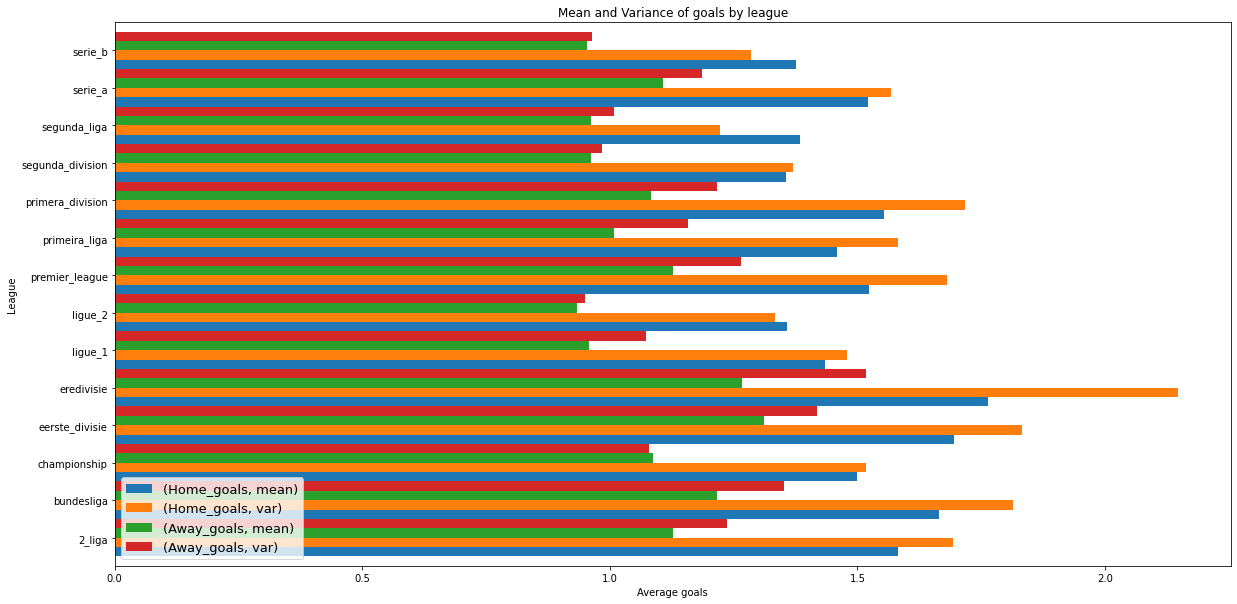

In [211]:
all_leagues_df = pd.concat(dictionary_df.values(), ignore_index=True)
all_leagues_df.groupby('League')['Home_goals', 'Away_goals'].mean().sort_values('Home_goals').plot(kind='barh')
plt.ylabel('League')
plt.xlabel('Average goals')
plt.title('Average goals by league')
leg=plt.legend(loc='lower right', fontsize=13, ncol=1)
plt.show()

all_leagues_df = pd.concat(dictionary_df.values(), ignore_index=True)
all_leagues_df.groupby('League')['Home_goals', 'Away_goals'].agg(['mean','var']).plot(kind='barh', width=1, figsize=(20,10))
plt.ylabel('League')
plt.xlabel('Average goals')
plt.title('Mean and Variance of goals by league')
leg=plt.legend(loc='lower left', fontsize=13, ncol=1)
plt.show()


By looking at the data in the 2nd plot, can be seen the averages and
variances are fairly equal to one another, which would be the case if the
number of home goals and number of away goals are Poisson distributed. However, in many leagues the variance is slightly larger than the
mean, which is a sign of overdispersion in the Poisson case.

/var/folders/1k/nj5s4vvs6b1758sjrdg0hd_40000gp/T/ipykernel_11463/2638225296.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_leagues_df[all_leagues_df['Season'] > 2015].groupby('League')['Home_goals', 'Away_goals'].mean().sort_values('Home_goals').plot(kind='barh')


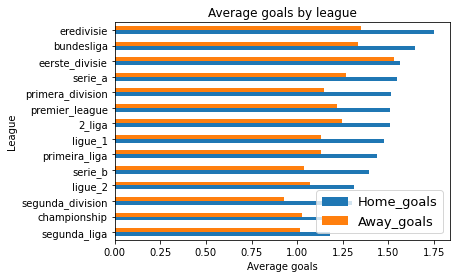

In [191]:
# Same plot > 2015
all_leagues_df = pd.concat(dictionary_df.values(), ignore_index=True)
all_leagues_df[all_leagues_df['Season'] > 2015].groupby('League')['Home_goals', 'Away_goals'].mean().sort_values('Home_goals').plot(kind='barh')
plt.ylabel('League')
plt.xlabel('Average goals')
plt.title('Average goals by league')
leg=plt.legend(loc='lower right', fontsize=13, ncol=1)
plt.show()

Explore the data: 
1) Home advantage

Text(0.5, 1.0, 'All seasons and leagues')

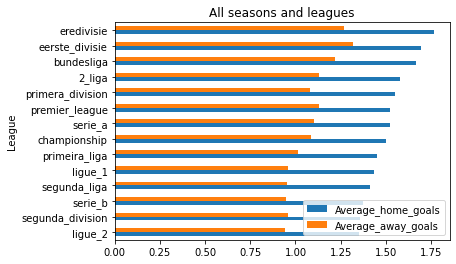

In [187]:
Av_home_goals = pd.DataFrame(columns=['League', 'Season', 'Average_home_goals', 'Average_away_goals'])
for i, df in enumerate(dictionary_df.values()):
    Av_home_goals.loc[i] = [df.at[df.first_valid_index(), 'League']] + [df.at[df.first_valid_index(),'Season']]+[df.Home_goals.mean()]+[df.Away_goals.mean()]

Av_home_goals.groupby('League').mean().sort_values('Average_home_goals').plot(kind='barh')
plt.ylabel('League')
plt.title('All seasons and leagues')


Same plot but only for more recent years (>2015):
Shows the home advantage becoming slightly less significant in recent years

/var/folders/1k/nj5s4vvs6b1758sjrdg0hd_40000gp/T/ipykernel_11463/400438945.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Av_home_goals[Av_home_goals['Season'] > 2015].groupby('League')['Average_home_goals', 'Average_away_goals'].mean().sort_values('Average_home_goals').plot(kind='barh')


Text(0.5, 1.0, 'Seasons and leagues > 2015')

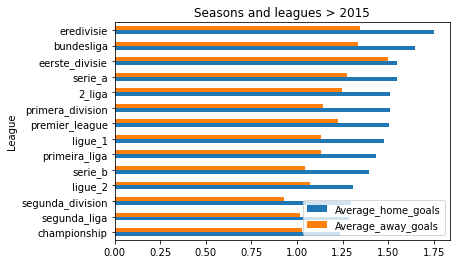

In [190]:
Av_home_goals[Av_home_goals['Season'] > 2015].groupby('League')['Average_home_goals', 'Average_away_goals'].mean().sort_values('Average_home_goals').plot(kind='barh')
plt.ylabel('League')
plt.title('Seasons and leagues > 2015')

2) looking at how similar scores are to the last time the same sides met each other: Explore the premier league 2021 for an example of this 

['Arsenal', 'Aston Villa', 'Bradford City', 'Charlton Athletic', 'Chelsea', 'Coventry City', 'Derby County', 'Everton', 'Ipswich Town', 'Leeds United', 'Leicester', 'Liverpool', 'Man. City', 'Man. Utd', 'Middlesbrough', 'Newcastle', 'Southampton', 'Sunderland', 'Tottenham Hotspur', 'West Ham']
20


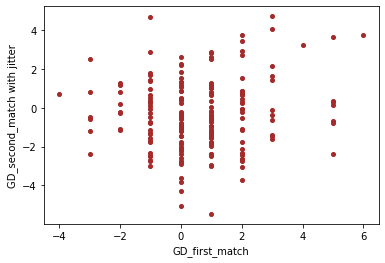

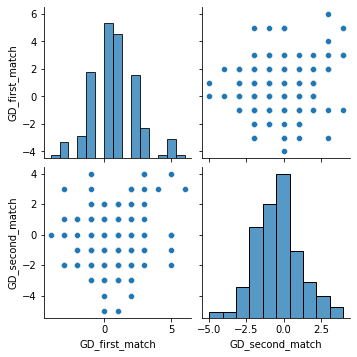

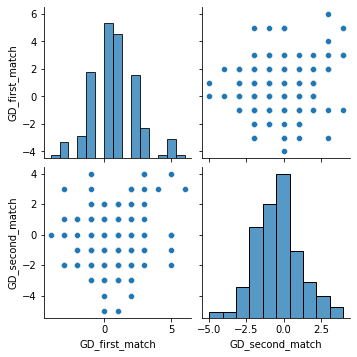

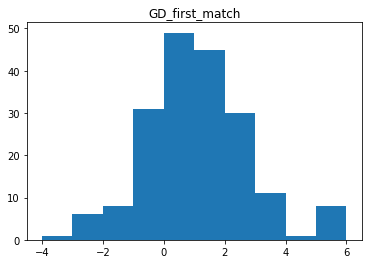

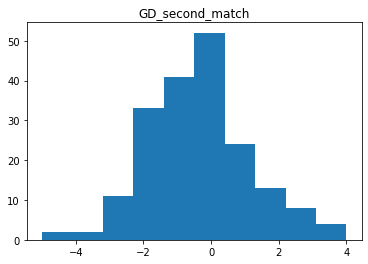

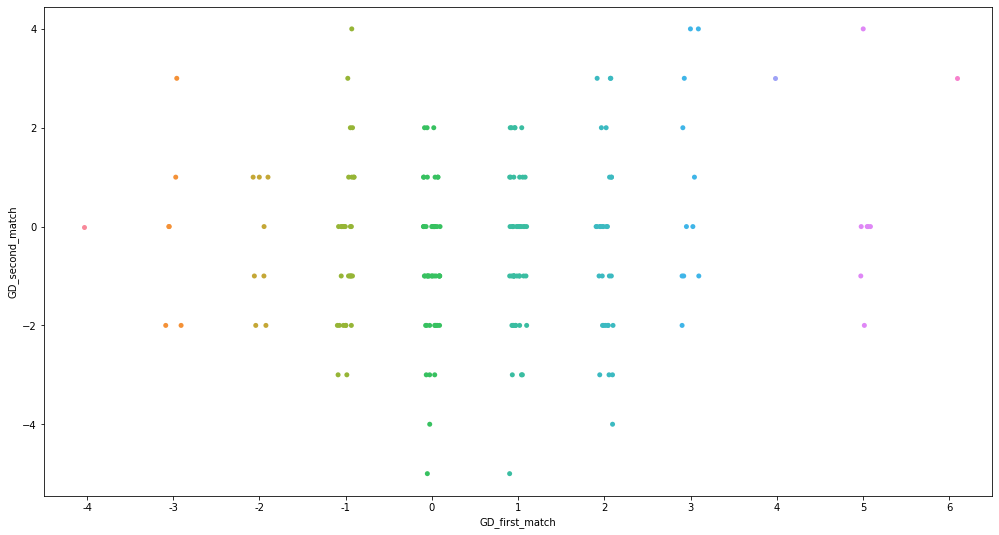

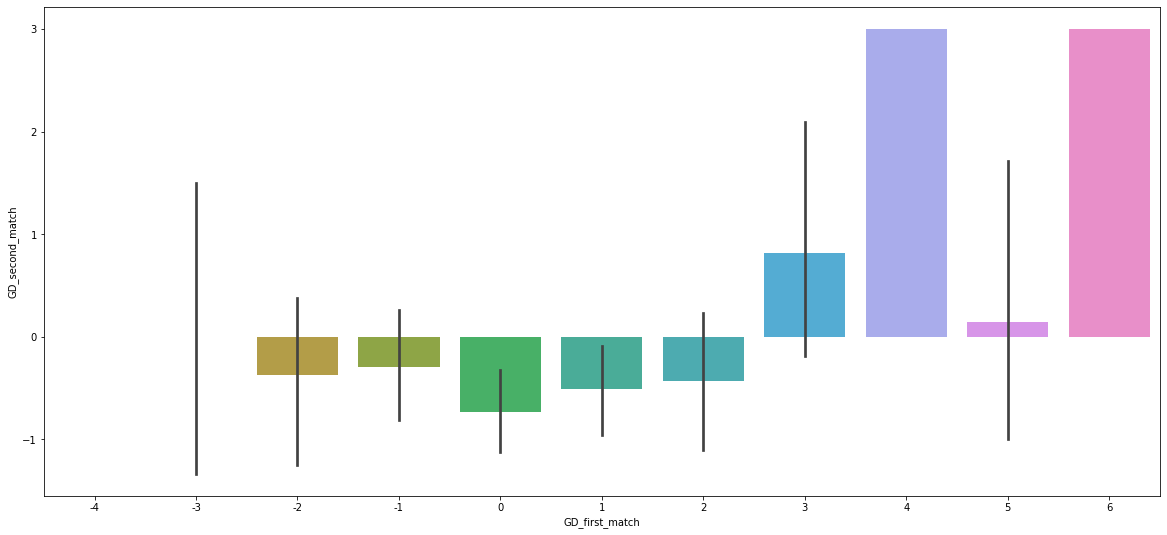

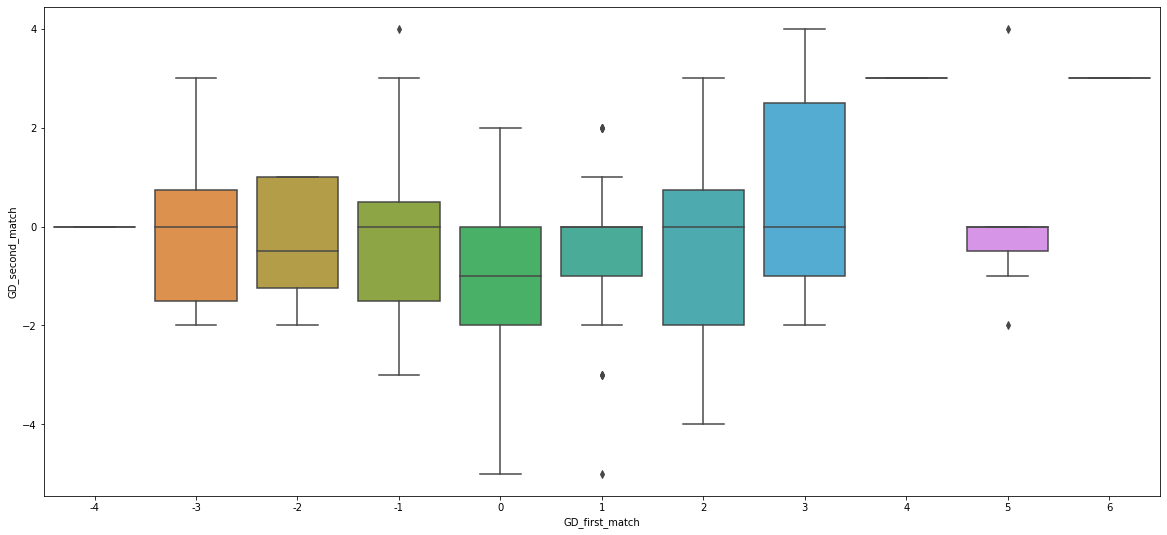

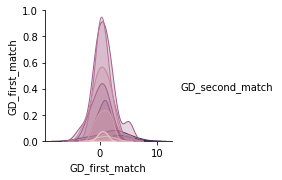

In [71]:
premier_league_2021 = dictionary_df['Results_2001_premier_league']
teams = premier_league_2021['Home_Team'].unique()
print(sorted(teams))
print(len(teams))

last_meet_df = pd.DataFrame(columns = ['Teams_pair1', 'Teams_pair2', 'GD_first_match', 'GD_second_match'])
index = premier_league_2021.first_valid_index()
last_index = index + len(premier_league_2021)
while index<last_index: 
    team_1 = premier_league_2021.at[index, 'Home_Team']
    team_2 = premier_league_2021.at[index, 'Away_Team']
    teams_pair1 = team_1 + ' & ' + team_2
    teams_pair2 = team_2 + ' & ' + team_1
    
    if teams_pair1 not in list(last_meet_df['Teams_pair2']):
        GD1 = premier_league_2021.at[index, 'Match_goal_difference']
        second_match = premier_league_2021[(premier_league_2021['Home_Team'] == team_2) & (premier_league_2021['Away_Team'] == team_1)]    
        GD2 = -second_match.at[second_match.first_valid_index(), 'Match_goal_difference']
        last_meet_df.loc[index] = [teams_pair1] + [teams_pair2] + [GD1] + [GD2]
    index +=1
    

# def get_last_meet_data(df):
def Jitter(values, jitter):
    n = len(values)
    return np.random.uniform(-jitter, +jitter, n) + values

y = Jitter(last_meet_df['GD_second_match'],0.9)
x = last_meet_df['GD_first_match']
plt.plot(x,y,'o',markersize=4, color='brown')
plt.xlabel('GD_first_match')
plt.ylabel('GD_second_match with jitter')
plt.show()

import seaborn as sns
sns.pairplot(last_meet_df[['GD_first_match','GD_second_match']])
sns.pairplot(last_meet_df[['GD_first_match','GD_second_match']])
plt.show()

plt.hist(last_meet_df['GD_first_match'])
plt.title('GD_first_match')
plt.show()
plt.hist(last_meet_df['GD_second_match'])
plt.title('GD_second_match')
plt.show()

# fig = plt.figure(figsize=(20,20))
# sns.heatmap(last_meet_df.Team_1, last_meet_df.GD_second_match).corr()
# fig, ax = plt.subplots(figsize=(10,6))
# sns.heatmap(last_meet_df['GD_first_match','GD_second_match'].corr(), center=0)
# ax.set_title('Multi')
# sns.pairplot(last_meet_df)
plt.figure(figsize=(17,9))
sns.stripplot(x="GD_first_match", y="GD_second_match", data=last_meet_df, jitter=True)

plt.figure(figsize=(20,9))
sns.barplot(x="GD_first_match", y="GD_second_match", data=last_meet_df)

plt.figure(figsize=(20,9))
sns.boxplot(x="GD_first_match", y="GD_second_match", data=last_meet_df)

sns.pairplot(last_meet_df, hue='GD_second_match')



Empty DataFrame
Columns: []
Index: []
